# Pessimistic Neighbourhood Aggregation for States in Reinforcement Learning

*Author: Maleakhi Agung Wijaya  
Supervisors: Marcus Hutter, Sultan Javed Majeed  
Date Created: 21/12/2017*

In [1]:
import random
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output

In [2]:
# Set grid color for seaborn
sns.set(style="whitegrid")

## Mountain Car Environment

**Mountain Car** is a standard testing domain in Reinforcement Learning, in which an under-powered car must drive up a steep hill. Since gravity is stronger than the car's engine, even at full throttle, the car cannot simply accelerate up the steep slope. The car is situated in a valley and must learn to leverage potential energy by driving up the opposite hill before the car is able to make it to the goal at the top of the rightmost hill.

**Technical Details**
- *State:* feature vectors consisting of velocity and position represented by an array [velocity, position]
- *Reward:* -1 for every step taken, 0 for achieving the goal
- *Action:* (left, neutral, right) represented by (-1, 0, 1)
- *Initial state:* velocity = 0.0, position = -0.5 represented by [0.0, -0.5]
- *Terminal state:* position >= 0.6
- *Boundaries:* velocity = (-0.07, 0.07), position = (-1.2, 0.6)
- *Update function:* velocity = velocity + (Action) \* 0.001 + cos(3\*Position) * (-0.0025), position = position + velocity

In [3]:
class MountainCarEnvironment:
    """
    Description: Environment for Mountain Car problem, adapted from Sutton and Barto's Introduction to Reinforcement Learning.
    Author: Maleakhi Agung Wijaya
    """
    VELOCITY_BOUNDARIES = (-0.07, 0.07)
    POSITION_BOUNDARIES = (-1.2, 0.6) 
    
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
   
    # Constructor for MountainCarEnvironment
    # Input: agent for the MountainCarEnvironment
    # Output: MountainCarEnvironment object
    def __init__(self, car):
        self.car = car
        self.reset()
        
    # Compute next state (feature)
    # Output: [new velocity, new position]
    def nextState(self, action):
        # Get current state (velocity, position) and the action chosen by the agent
        velocity = self.car.state[0]
        position = self.car.state[1]
        
        # Calculate the new velocity and new position
        velocity += action * 0.001 + math.cos(3*position) * (-0.0025)
        # Consider boundary for velocity
        if (velocity < MountainCarEnvironment.VELOCITY_BOUNDARIES[0]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[0]
        elif (velocity > MountainCarEnvironment.VELOCITY_BOUNDARIES[1]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[1]
            
        position += velocity
        # Consider boundary for position
        if (position < MountainCarEnvironment.POSITION_BOUNDARIES[0]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[0]
            velocity = 0
        elif (position > MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[1]
        
        new_state = [velocity, position]
        return(new_state)
    
    # Reset to the initial state   
    def reset(self):
        self.car.state[0] = MountainCarEnvironment.INITIAL_VELOCITY
        self.car.state[1] = MountainCarEnvironment.INITIAL_POSITION
        
    # Give reward for each of the chosen action, depending on what the next state that the agent end up in
    # Output: terminal state = 0, non-terminal state = -1
    def calculateReward(self):
        # Get current position of the agent
        position = self.car.state[1]
        
        # Determine the reward given
        if (position >= MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            return(MountainCarEnvironment.REWARD_TERMINAL)
        else:
            return(MountainCarEnvironment.REWARD_STEP)

## KNN-TD Agent

**kNN-TD** combines the concept of *K-Nearest Neighbours* and *TD-Learning* to learn and evaluate Q values in both continuous and discrete state space RL problems. This method is especially useful in continuous states RL problems as the number of (state, action) pairs is very large and thus impossible to store and learn this information. By choosing a particular k-values and decided some initial points over continuous states, one can estimate Q values based on calculated the weighted average of Q values of the k-nearest neighbours for the state that the agent are currently in and use that values to decide the next move using some decision methods (i.e. UCB or epsilon-greedy). As for the learning process, one can update all of the k-nearest neighbours that contribute for the Q calculation.

**Algorithm:**
1. Cover the whole state space by some initial Q(s,a) pairs, possibly scatter it uniformly across the whole state space and give an initial value of 0/ -1
2. When an agent in a particular state, get the feature vectors representing the state and possible actions from the state
3. For each possible action from the state, calculate Q(s,a) pairs by taking the expected value from previous Q values based on k-nearest neighbours of a particular action.  
*Steps for k-nearest neighbours:*
    - Standardise every feature in the feature vectors to (-1, 1) or other ranges to make sure that one feature scale not dominate the distance calculation (i.e. if position ranges between (-50, 50) and velocity (-0.7, 0.7) position will dominate distance calculation).
    - Calculate the distance between current state and all of other points with the same action using distance formula (i.e. Euclidean distance) and store the k-nearest neighbours to knn vector, and it's distance (for weight) in weight vector
    - Determine the probability p(x) for the expected value by using weight calculation (i.e. weight = 1/distance). To calculate weight, one can use other formula as long as that formula gives more weight to closer point. To calculate p(x) just divide individual weight with sum of all weights to get probability
    - Estimate the Q(s,a) pairs using expectation formula from kNN previous Q values
4. Using epsilon greedy/ UCB/ other decision methods to choose the next move
5. Observe the reward and update the Q values for all of the neighbours on knn vector using SARSA or Q Learning. (on the code below, I use Q Learning)
6. Repeat step 2-5

In [4]:
class KNNAgent:
    """
    Description: Mountain Car problem agent based on kNN-TD(0) algorithm 
    Author: Maleakhi Agung Wijaya
    """
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    INITIAL_VALUE = -1
    
    ACTIONS = [-1, 0, 1]
    GAMMA = 0.995
    EPSILON = 0.05
    
    INDEX_DISTANCE = 0
    INDEX_ORIGINAL = 1
    INDEX_WEIGHT = 2
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
    
    # Constructor
    # Input: size of the storage for previous Q values, parameters for how many neighbours which the agent will choose
    def __init__(self, size, k):
        self.state = [KNNAgent.INITIAL_VELOCITY, KNNAgent.INITIAL_POSITION]
        self.q_storage = []
        self.k = k # fixed number of nearest neighbours that we will used
        self.alpha = 1 # will be decaying and change later
        
        # Storage of the k nearest neighbour (data) and weight (inverse of distance) for a particular step
        self.knn = []
        self.weight = []
        
        # Initialise the storage with random point 
        for i in range(size):
            initial_action = random.randint(-1, 1)
            initial_state = [random.uniform(-0.07, 0.07), random.uniform(-1.2, 0.6)]
            
            # Each data on the array will consist of state, action pair + value
            data = {"state": initial_state, "value": KNNAgent.INITIAL_VALUE, "action": initial_action}
            self.q_storage.append(data)
    
    # Find all index for a given value
    # Input: value, list to search
    # Output: list of all index where you find that value on the list
    def findAllIndex(self, value, list_value):
        indices = []
        for i in range(len(list_value)):
              if (value == list_value[i]):
                    indices.append(i)
        
        return indices
    
    # Standardise feature vector given
    # Input: feature vector to be standardised
    # Output: standardised feature vector
    def standardiseState(self, state):
        standardised_state = []
        
        # The number is taken from VELOCITY_BOUNDARIES and POSITION_BOUNDARIES using normal standardisation formula
        standardised_velocity = 2 * ((state[0]+0.07) / (0.07+0.07)) - 1
        standardised_position = 2 * ((state[1]+1.2) / (0.6+1.2)) - 1
        
        standardised_state.append(standardised_velocity)
        standardised_state.append(standardised_position)
        
        return(standardised_state)
    
    # Calculate Euclidean distance between 2 vectors
    # Input: 2 feature vectors
    # Output: distance between them
    def calculateDistance(self, vector1, vector2):
        return(math.sqrt((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2))
    
    # Calculate total weight
    # Input: list of weights
    # Output: total weight
    def calculateTotalWeight(self, weight_list):
        total_weight = 0
        for i in range(len(weight_list)):
            total_weight += weight_list[i][KNNAgent.INDEX_WEIGHT]
        
        return(total_weight)
    
    # Apply the kNN algorithm for feature vector and store the data point on the neighbours array
    # Input: feature vector of current state, actions array consisting of all possible actions, list that will store knn data and weights data
    # Output: vector containing the value of taking each action (left, neutral, right)
    def kNNTD(self, state, actions, knn_list, weight_list):
        approximate_action = []
        
        # Get the standardised version of state
        standardised_state = self.standardiseState(state)
        
        # Loop through every element in the storage array and only calculate for particular action
        for action in actions:
            temp = [] # array consisting of tuple (distance, original index, weight) for each point in the q_storage
            for i in range(len(self.q_storage)):
                data = self.q_storage[i]
                # Only want to calculate the nearest neighbour state which has the same action
                if (data["action"] == action):
                    vector_2 = data["state"]
                    standardised_vector_2 = self.standardiseState(vector_2)
                    distance = self.calculateDistance(standardised_state, standardised_vector_2)
                    index = i
                    weight = 1 / (1+distance**2) # weight formula
            
                    # Create the tuple and append that to temp
                    temp.append(tuple((distance, index, weight)))
                else:
                    continue
        
            # After we finish looping through all of the point and calculating the standardise distance,
            # Sort the tuple based on the distance and only take k of it and append that to the neighbours array
            # We also need to calculate the total weight to make it into valid probability that we can compute it's expectation
            sorted_temp = sorted(temp, key=lambda x: x[0])
            for i in range(self.k):
                try:
                    weight_list.append(sorted_temp[i])
                    knn_list.append(self.q_storage[sorted_temp[i][KNNAgent.INDEX_ORIGINAL]])
                except IndexError:
                    sys.exit(0)
            
            # Calculate the expected value of the action and append it to the approximate_action array
            expected_value = 0
            total_weight = self.calculateTotalWeight(weight_list[(action+1)*self.k:(action+1)*self.k + self.k])
            for i in range((action+1)*self.k, (action+1)*self.k + self.k):
                weight = weight_list[i][KNNAgent.INDEX_WEIGHT]
                probability = weight / total_weight
                expected_value += probability * knn_list[i]["value"]
                
            approximate_action.append(expected_value)
        
        return(approximate_action)
    
    # Select which action to choose, whether left, neutral, or right (using epsilon greedy)
    # Output: -1 (left), 0 (neutral), 1 (right)
    def selectAction(self):
        # First call the knn-td algorithm to determine the value of each Q(s,a) pairs
        action_value = self.kNNTD(self.state, KNNAgent.ACTIONS, self.knn, self.weight)
        
        # Use the epsilon-greedy method to choose value
        random_number = random.uniform(0.0, 1.0)
        if (random_number <= KNNAgent.EPSILON):
            action_chosen = random.randint(-1, 1)
        else:
            # Return the action with highest Q(s,a)
            possible_index = self.findAllIndex(max(action_value), action_value)
            action_chosen = possible_index[random.randrange(len(possible_index))] - 1
        
        # Only store chosen data in the knn and weight list
        # Clearance step
        chosen_knn = []
        chosen_weight = []
        for i in range(self.k*(action_chosen+1), self.k*(action_chosen+1) + self.k):
            chosen_knn.append(self.knn[i])
            chosen_weight.append(self.weight[i])
        self.knn = chosen_knn
        self.weight = chosen_weight

        return action_chosen
    
    # Calculate TD target based on Q Learning/ SARSAMAX
    # Input: Immediate reward based on what the environment gave
    # Output: TD target based on off policy Q learning
    def calculateTDTarget(self, immediate_reward):
        # Consider condition on the final state, return 0 immediately
        if (immediate_reward == KNNAgent.REWARD_TERMINAL):
            return(immediate_reward)
        
        knn_prime = []
        weight_prime = []
        action_value = self.kNNTD(self.state, KNNAgent.ACTIONS, knn_prime, weight_prime)
        
        return(immediate_reward + KNNAgent.GAMMA*max(action_value))
    
    # Q learning TD updates on every neighbours on the kNN based on the contribution that are calculated using probability weight
    # Input: Immediate reward based on what the environment gave
    def TDUpdate(self, immediate_reward, alpha):
        self.alpha = alpha
        # First, calculate the TD target
        td_target = self.calculateTDTarget(immediate_reward)
        
        # Iterate every kNN and update using Q learning method based on the weighting
        total_weight = self.calculateTotalWeight(self.weight)
        for i in range(len(self.weight)):
            index = self.weight[i][KNNAgent.INDEX_ORIGINAL]
            probability = self.weight[i][KNNAgent.INDEX_WEIGHT] / total_weight
            
            # Begin updating
            td_error = td_target - self.q_storage[index]["value"]
            self.q_storage[index]["value"] = self.q_storage[index]["value"] + self.alpha*td_error*probability
        
        self.cleanList() # clean list to prepare for another step
            
    # Clear the knn list and also the weight list
    def cleanList(self):
        self.knn = []
        self.weight = []

## KNN Main Function

**KNN Main function** is responsible for initiating the KNN agent, environment and handling agent-environment interaction. It consists of a non-terminate inner loop that direct agent decision while also giving reward and next state from the environment. This inner loop will only break after the agent successfully get out of the environment, which in this case the mountain. The outer loop can also be created to control the number of episodes which the agent will perform before the main function ends.

Apart from handling agent-environment interaction, main function also responsible to display three kinds of visualisation which will be explain below the appropriate graph.

In [5]:
# Generate decaying alphas
# Input: minimum alpha, number of episodes
# Output: list containing alpha
def generateAlphas(minimum_alpha, n_episodes):
    return(np.linspace(1.0, MIN_ALPHA, N_EPISODES))

N_EPISODES = 1000
MIN_ALPHA = 0.02
alphas = generateAlphas(MIN_ALPHA, N_EPISODES)

In [6]:
# Initialise the environment and the agent
size = 1000 # size of the q_storage 
k = 6 # knn parameter (this is the best k so far that we have)
agent = KNNAgent(size, k)
mountain_car_environment = MountainCarEnvironment(agent)

# Used for graphing purposes
count_step = [] # counter for how many step in each episodes

In [7]:
# Iterate the process, train the agent (training_iteration episodes)
training_iteration = N_EPISODES
for i in range(training_iteration):
    step = 0
    alpha = alphas[i]
    mountain_car_environment.reset()
    while (True):
        action = agent.selectAction()
        next_state = mountain_car_environment.nextState(action)
        
        # Change agent current state and getting reward
        agent.state = next_state
        immediate_reward = mountain_car_environment.calculateReward()
        
        # Used for graphing
        step += 1
        
        # Test for successful learning
        if (immediate_reward == MountainCarEnvironment.REWARD_TERMINAL):
            agent.TDUpdate(immediate_reward, alpha)
            count_step.append(step)
            
            clear_output(wait=True) # clear previous output
            # Create table
            d = {"Steps": count_step}
            episode_table = pd.DataFrame(data=d, index=np.arange(1, len(count_step)+1))
            episode_table.index.names = ['Episodes']
            display(episode_table)
            break
        
        # Update using Q Learning and kNN
        agent.TDUpdate(immediate_reward, alpha)

,Steps
Episodes,
1,4335
2,8517
3,1687
4,906
5,1333
6,1377
7,498
8,609
9,649


The table above displays total step data taken from 1000 episodes simulation. The first column represents episode and the second column represents total steps taken in a particular episode. It can be seen from the table that during the first few episodes, the agent hasn't learned the environment and hence it chose action unoptimally represented by huge number of steps taken to get to goal. Despite that, after experiencing hundred of episodes the agent have learnt the environment and Q values which enable it to reach the goal in just 200-400 steps.

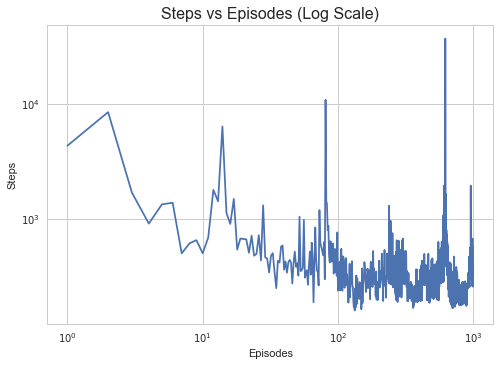

In [8]:
# Create graph for step vs episodes
y = count_step
x = np.arange(1, len(y) + 1)

plt.plot(x, y)
plt.title("Steps vs Episodes (Log Scale)", fontsize=16)
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.xscale('log')
plt.yscale('log')

plt.show()

The line plot visualise the table that are explained above. On the y axis, the plot displays steps taken on each episode, while on the x axis the number of episodes (1000 in the simulation). The line plot is displayed in log-log scale to make it easy to visualise small fluctuation within episode and making sure that large steps in first few episodes don't dominate the graph. From the plot we can see that the overall trend is going downward. This result implies that over many episodes the Q values is getting better and better which eventually will converge to true Q values. Consequently, the agent perform better and better and the step taken to get out of the mountain will decrease with respect to number of episodes.

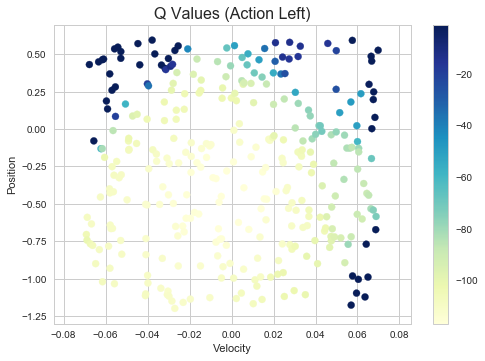

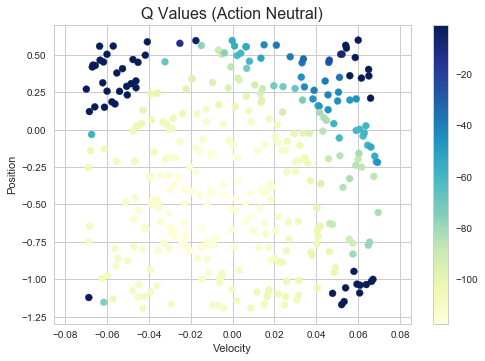

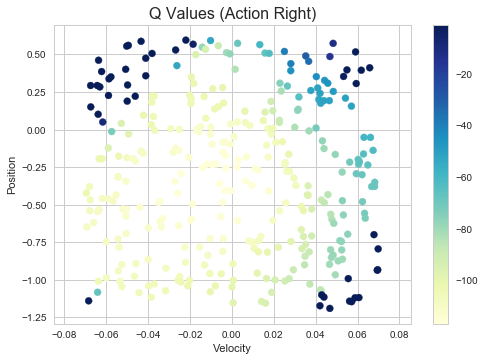

In [9]:
# Create heatmap for Q values
data = pd.DataFrame()
data_left = []
data_neutral = []
data_right = []

position_left = []
position_neutral = []
position_right = []

velocity_left = []
velocity_neutral = []
velocity_right = []

# Sort q_storage based on position and velocity
q_storage_sorted = sorted(agent.q_storage, key=lambda k: k['state'][0])  
# Separate action left, neutral, and right
for elem in q_storage_sorted:
    if (elem["action"] == -1):
        data_left.append(elem["value"])
        position_left.append(elem["state"][1])
        velocity_left.append(elem["state"][0])
    elif (elem["action"] == 0):
        data_neutral.append(elem["value"])
        position_neutral.append(elem["state"][1])
        velocity_neutral.append(elem["state"][0])
    else:
        data_right.append(elem["value"])
        position_right.append(elem["state"][1])
        velocity_right.append(elem["state"][0])

# Make scatter plot for 3 actions (left, neutral, right)
# Left
plt.scatter(x=velocity_left, y=position_left, c=data_left, cmap="YlGnBu")
plt.title("Q Values (Action Left)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Neutral
plt.scatter(x=velocity_neutral, y=position_neutral, c=data_neutral, cmap="YlGnBu")
plt.title("Q Values (Action Neutral)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Right
plt.scatter(x=velocity_right, y=position_right, c=data_right, cmap="YlGnBu")
plt.title("Q Values (Action Right)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

Three scatter plots above display Q values for every action on the last episode (1000). Y axis represents position and x axis represents velocity of the 1000 points that we scattered random uniformly initially. To represent Q values for every point, these scatter plots use color indicating value that can be seen from the color bar. When the point is darker, the Q value is around -20. On the other hand, if the point is lighter the Q value is around -100. These Q values are later used for comparison with PNA Algorithm

## PNA Agent

**PNA** may be viewed as a refinement for kNN, with k adapting to the situation. On the one hand, it is beneficial to use large k since that means large data can be learn from. On the other hand, it is beneficial to learn only from the most similar past experiences (small k), as the data they provide should be the most relevant. 

PNA suggests that when predicting the value of an action a in a state s, k should be chosen dynamically to minimise:

![equation](pictures/variance.jpg)

where c = 1 and Var(Nsa) is the variance of observed rewards in the neighbourhood Nsa. This is a negative version of the term endorsing exploration in the UCB algorithm. Here it promotes choosing neighbourhoods that contain as much data as possible but with small variation between rewards. For example, in the ideal choice of k, all k nearest neighbours of (s, a) behave similarly, but actions farther away behave very differently. 

Action are chosen optimistically according to the UCB:

![equation](pictures/action_selection.jpg)  

with c > 0 a small constant. The upper confidence bound is composed of two terms: The first terms is the estimated value, and the second term is an exploration bonus for action whose value is uncertain. Actions can have uncertain value either because they have rarely been selected or have a high variance among previous returns. Meanwhile, the neighbourhoods are chosen "pessimistically" for each action to minimise the exploration bonus.

**Algorithm:**
1. Cover the whole state space by some initial Q(s,a) pairs, possibly scatter it uniformly across the whole state space and give an initial value of 0/ -1
2. When an agent in a particular state, get the feature vectors representing the state and possible actions from the state
3. For each possible action from the state, calculate Q(s,a) pairs by taking the expected value from previous Q values based on k-nearest neighbours of a particular action. With PNA, we also need to dynamically consider the k values  
*Steps for PNA:*
    - Standardise every feature in the feature vectors to (-1, 1) or other ranges to make sure that one feature scale not dominate the distance calculation (i.e. if position ranges between (-50, 50) and velocity (-0.7, 0.7) position will dominate distance calculation).
    - Calculate the distance between current state and all of other points with the same action using distance formula (i.e. Euclidean distance) and sort based on the closest distance
    - Determine k by minimising the variance function described above
    - Store the k-nearest neighbours to knn vector, and it's distance (for weight) in weight vector
    - Determine the probability p(x) for the expected value by using weight calculation (i.e. weight = 1/distance). To calculate weight, one can use other formula as long as that formula gives more weight to closer point. To calculate p(x) just divide individual weight with sum of all weights to get probability
    - Estimate the Q(s,a) pairs using expectation formula from kNN previous Q values
4. Using epsilon greedy/ UCB/ other decision methods to choose the next move
5. Observe the reward and update the Q values for only the closest neighbour (1 point or chosen by hyperparametric) from KNN array using SARSA or Q Learning. (on the code below, I use Q Learning)
6. Repeat step 2-5

In [21]:
class PNAAgent:
    """
    Description: Mountain Car problem agent based on PNA algorithm adapted from Marcus Hutter's literatures
    Author: Maleakhi Agung Wijaya
    """
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    INITIAL_VALUE = -1
    
    ACTIONS = [-1, 0, 1]
    GAMMA = 0.995
    C = 0.01 # UCB constant
    EPSILON = 0.05
    RADIUS = 1
    
    INDEX_DISTANCE = 0
    INDEX_ORIGINAL = 1
    INDEX_WEIGHT = 2
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
    
    # Constructor
    # Input: size of the storage for previous Q values
    def __init__(self, size):
        self.state = [PNAAgent.INITIAL_VELOCITY, PNAAgent.INITIAL_POSITION]
        self.q_storage = []
        self.alpha = 1 # choose fixed alpha, but we will vary alpha later
        
        # Storage of the k nearest neighbour (data) and weight (inverse of distance) for a particular step
        self.knn = []
        self.weight = []
        self.k_history = [] # used to store history of k chosen for each action
        
        # For plotting expected PNA function graph
        self.var_function_left = []
        self.var_function_neutral = []
        self.var_function_right = []
        self.converge_function_left = []
        self.converge_function_neutral = []
        self.converge_function_right = []
        self.episode = 0 # keep count of how many episodes for plotting purposes as well
        
        # Initialise the storage with random point 
        for i in range(size):
            initial_value = PNAAgent.INITIAL_VALUE
            initial_action = random.randint(-1, 1)
            initial_state = [random.uniform(-0.07, 0.07), random.uniform(-1.2, 0.6)]
            
            # Fill the graph with all possible k
            if (initial_action == -1):
                self.var_function_left.append(0)
                self.converge_function_left.append(0)
            elif (initial_action == 0):
                self.var_function_neutral.append(0)
                self.converge_function_neutral.append(0)
            else:
                self.var_function_right.append(0)
                self.converge_function_right.append(0)
            
            # Each data on the array will consist of state, action pair + value
            data = {"state": initial_state, "value": initial_value, "action": initial_action}
            self.q_storage.append(data)
            
        # Since the k start at 2 that we want to calculate, just pop 1
        self.var_function_left.pop()
        self.var_function_neutral.pop()
        self.var_function_right.pop()
        self.converge_function_left.pop()
        self.converge_function_neutral.pop()
        self.converge_function_right.pop()
    
    # Standardise feature vector given
    # Input: feature vector to be standardised
    # Output: standardised feature vector
    def standardiseState(self, state):
        standardised_state = []
        standardised_velocity = 2 * ((state[0]+0.07) / (0.07+0.07)) - 1
        standardised_position = 2 * ((state[1]+1.2) / (0.6+1.2)) - 1
        standardised_state.append(standardised_velocity)
        standardised_state.append(standardised_position)
        
        return(standardised_state)
    
    # Find all index for a given value
    # Input: value, list to search
    # Output: list of all index where you find that value on the list
    def findAllIndex(self, value, list_value):
        indices = []
        for i in range(len(list_value)):
              if (value == list_value[i]):
                    indices.append(i)
        
        return indices
    
    # Calculate Euclidean distance between 2 vectors
    # Input: 2 feature vectors
    # Output: distance between them
    def calculateDistance(self, vector1, vector2):
        return(math.sqrt((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2))
    
    # Calculate total weight
    # Input: list of weights
    # Output: total weight
    def calculateTotalWeight(self, weight_list):
        total_weight = 0
        for i in range(len(weight_list)):
            total_weight += weight_list[i][PNAAgent.INDEX_WEIGHT]
        
        return(total_weight)
            
    # Clear the knn list, k_history, and also the weight list
    def cleanList(self):
        self.knn = []
        self.weight = []
        self.k_history = []
    
    # Choose the appropriate k by minimising variance and maximising the number of data to learn
    # Input: sorted neighbourhood list based on distance (distance, index, weight)
    # Output: k (numbers of nearest neighbour) that minimise neighbourhood variance function
    def chooseK(self, neighbourhood_list):
        data_list = []
        # Extract the data (Q value from the neighbourhood_list) and append it to the data_list
        for data in neighbourhood_list:
            data_list.append(self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["value"])
            action = self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["action"]
            
        # Initialise minimum variance
        minimum_k = 2 # Variable that will be return that minimise the variance of the neighbourhood
        minimum_function = self.neighbourhoodVariance(1, data_list[:2])
        
        # For plotting variance function graph
        list_var = []
        if (action == -1):
            list_var = self.var_function_left
        elif (action == 0):
            list_var = self.var_function_neutral
        else:
            list_var = self.var_function_right
        
        list_var[0] += minimum_function
        
        if (self.episode > 900):
            list_var_converge = []
            if (action == -1):
                list_var_converge = self.converge_function_left
            elif (action == 0):
                list_var_converge = self.converge_function_neutral
            else:
                list_var_converge = self.converge_function_right
            
            list_var_converge[0] += minimum_function
        
        previous_sum_variance = np.var(data_list[:2]) * 2
        previous_mean = np.mean(data_list[:2])
        k = 2
        # Iterate to find optimal k that will minimise the neighbourhood variance function
        for i in range(2, len(neighbourhood_list)):
            target_x = data_list[i]
            mean = (previous_mean * k + target_x) / (k + 1)
            current_sum_variance = previous_sum_variance + (target_x - previous_mean) * (target_x - mean)
            
            # Update for next iteration
            k = k + 1
            previous_sum_variance = current_sum_variance
            previous_mean = mean
            
            function = self.neighbourhoodVariance(1, [], previous_sum_variance / k, k)
            list_var[k-2] += function
            if (self.episode > 900):
                list_var_converge[k-2] += function
            # Update the k value and minimum var value if find parameter which better minimise than the previous value
            if (function <= minimum_function):
                minimum_k = k
                minimum_function = function
            
        return(minimum_k)
    
    # PNA variance function that needed to be minimise
    # Input: constant c, list containing data points
    # Output: calculation result from the neighbourhood variance function
    def neighbourhoodVariance(self, c, data_list, var = None, k = None):
        if (var == None):
            return(math.sqrt(c * np.var(data_list) / len(data_list)))
        else:
            return(math.sqrt(c * var / k))
    
    # Get starting index for the weight list
    # Input: action, k_history
    # Output: starting index for the weight list
    def getStartingIndex(self, action, k_history):
        count_action = action + 1
        if (count_action == 0):
            return(0)
        else:
            index = 0
            for i in range(count_action):
                index += k_history[i]
            return(index)
        
    # Apply the PNA algorithm for feature vector and store the data point on the neighbours array
    # Input: feature vector of current state, actions array consisting of all possible actions, list that will store knn data and weights data, k_history
    # Output: vector containing the value of taking each action (left, neutral, right)
    def PNA(self, state, actions, knn_list, weight_list, k_history):
        approximate_action = []
        
        # Get the standardised version of state
        standardised_state = self.standardiseState(state)
        
        # Loop through every element in the storage array and only calculate for particular action
        for action in actions:
            temp = [] # array consisting of tuple (distance, original index, weight) for each point in the q_storage
            for i in range(len(self.q_storage)):
                data = self.q_storage[i]
                # Only want to calculate the nearest neighbour state which has the same action
                if (data["action"] == action):
                    vector_2 = data["state"]
                    standardised_vector_2 = self.standardiseState(vector_2)
                    distance = self.calculateDistance(standardised_state, standardised_vector_2)
                    index = i
                    weight = 1 / (1+distance**2)
            
                    # Create the tuple and append that to temp
                    temp.append(tuple((distance, index, weight)))
                else:
                    continue
            
            # After we finish looping through all of the point and calculating the standardise distance,
            # Sort the tuple based on the distance and only take k of it and append that to the neighbours array
            sorted_temp = sorted(temp, key=lambda x: x[0])
            # Get the value of the k dynamically
            k = self.chooseK(sorted_temp)
            k_history.append(k)
            
            for i in range(k):
                try:
                    weight_list.append(sorted_temp[i])
                    knn_list.append(self.q_storage[sorted_temp[i][PNAAgent.INDEX_ORIGINAL]])
                except IndexError:
                    sys.exit(0)
            
            # Calculate the expected value of the action and append it to the approximate_action array
            expected_value = 0
            # We also need to calculate the total weight to make it into valid probability that we can compute it's expectation
            total_weight = self.calculateTotalWeight(weight_list[self.getStartingIndex(action, k_history):self.getStartingIndex(action, k_history)+k])
            for i in range(self.getStartingIndex(action, k_history), self.getStartingIndex(action, k_history) + k):
                try:
                    weight = weight_list[i][PNAAgent.INDEX_WEIGHT]
                    probability = weight / total_weight
                    expected_value += probability * knn_list[i]["value"]
                except IndexError:
                    sys.exit(0)
                    
            approximate_action.append(expected_value)
        
        return(approximate_action)
    
    # Calculate TD target based on Q Learning/ SARSAMAX
    # Input: Immediate reward based on what the environment gave
    # Output: TD target based on off policy Q learning
    def calculateTDTarget(self, immediate_reward):
        # Condition if final state
        if (immediate_reward == PNAAgent.REWARD_TERMINAL):
            return(immediate_reward)
        
        k_history = []
        knn_prime = []
        weight_prime = []
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, knn_prime, weight_prime, k_history)
        
        return(immediate_reward + PNAAgent.GAMMA * max(action_value))
    
    # Q learning TD updates on every neighbours on the kNN based on the contribution that are calculated using probability weight
    # Input: Immediate reward based on what the environment gave
    def TDUpdate(self, immediate_reward, alpha):
        self.alpha = alpha
        # First, calculate the TD target
        td_target = self.calculateTDTarget(immediate_reward)
        
        try:
            # Update only the #radius closest point
            total_weight = self.calculateTotalWeight(self.weight[0:PNAAgent.RADIUS])
            for i in range(PNAAgent.RADIUS):
                index = self.weight[i][PNAAgent.INDEX_ORIGINAL]
                probability = self.weight[i][PNAAgent.INDEX_WEIGHT] / total_weight
                td_error = td_target - self.q_storage[index]["value"]
                self.q_storage[index]["value"] += self.alpha * td_error * probability
        except IndexError:
            total_weight = self.calculateTotalWeight(self.weight)
            for i in range(len(self.weight)):
                index = self.weight[i][PNAAgent.INDEX_ORIGINAL]
                probability = self.weight[i][PNAAgent.INDEX_WEIGHT] / total_weight
            
                # Begin updating
                td_error = td_target - self.q_storage[index]["value"]
                self.q_storage[index]["value"] += self.alpha * td_error * probability
        
        self.cleanList() # clean list to prepare for another step
    
    # Choosing based on Epsilon Greedy method
    # Input: action_value array consisting the Q value of every action
    # Output: action chosen (-1, 0, 1)
    def epsilonGreedy(self, action_value):
        # Use the epsilon-greedy method to choose value
        random_number = random.uniform(0.0, 1.0)
        if (random_number <= PNAAgent.EPSILON):
            action_chosen = random.randint(-1, 1)
        else:
            # Return the action with highest Q(s,a)
            possible_index = self.findAllIndex(max(action_value), action_value)
            action_chosen = possible_index[random.randrange(len(possible_index))] - 1
        
        return action_chosen
    
    # Getting the maximum of the ucb method
    # Input: action_value list, bonus_variance list
    # Output: action which maximise
    def maximumUCB(self, action_value, bonus_variance):
        max_index = 0
        max_value = action_value[0] + bonus_variance[0]
        
        # Check 1, 2 (all possible action)
        for i in range(1, 3):
            value = action_value[i] + bonus_variance[i]
            
            if (value >= max_value):
                max_value = value
                max_index = i
        
        return(max_index - 1) # return the action which maximise
        
    # Select which action to choose, whether left, neutral, or right (using UCB)
    # Output: -1 (left), 0 (neutral), 1 (right)
    def selectAction(self):
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, self.knn, self.weight, self.k_history)
        
        # Second term of ucb, calculate the bonus variance
        start_index = [] # used to calculate start index for each action
        finish_index = [] # used to calculate end index for each action
        for action in PNAAgent.ACTIONS:
            # Prevent index out of bound
            if (action != 1):
                # Data extraction
                start_index.append(self.getStartingIndex(action, self.k_history))
                finish_index.append(self.getStartingIndex(action+1, self.k_history))
            else:
                # Data extraction
                start_index.append(self.getStartingIndex(action, self.k_history))
                finish_index.append(len(self.weight))
            
        # Choose the action based on ucb method
        action_chosen = self.epsilonGreedy(action_value)
                               
        # Only store chosen data in the knn and weight list
        # Clearance step
        chosen_knn = []
        chosen_weight = []
        for i in range(start_index[action_chosen+1], finish_index[action_chosen+1]):
            chosen_knn.append(self.knn[i])
            chosen_weight.append(self.weight[i])
        self.knn = chosen_knn
        self.weight = chosen_weight
        
        return action_chosen

## PNA Main Function

**PNA Main function** is responsible for initiating the PNA agent, environment and handling agent-environment interaction. It consists of a non-terminate inner loop that direct agent decision while also giving reward and next state from the environment. This inner loop will only break after the agent successfully get out of the environment, which in this case the mountain or if it is taking too long to converge. The outer loop can also be created to control the number of episodes which the agent will perform before the main function ends.

Apart from handling agent-environment interaction, main function also responsible to display five kinds of visualisation. First, table/ DataFrame displaying episodes and step that are required by the agent to get out of the mountain on each episode. Second, scatter plot displaying steps on the y axis and episodes on the x axis to learn about algorithm convergence property. Third, expected standard error function for every actions. Fourth, heatmap of the Q value for the last episode. Lastly, as the k is dynamically changing each steps, I have created a heatmap indicating k chosen each steps for first episode and last episode.

In [5]:
# Generate decaying alphas
# Input: minimum alpha, number of episodes
# Output: list containing alpha
def generateAlphas(minimum_alpha, n_episodes):
    return(np.linspace(1.0, MIN_ALPHA, N_EPISODES))

N_EPISODES = 1000
MIN_ALPHA = 0.02
alphas = generateAlphas(MIN_ALPHA, N_EPISODES)

In [6]:
# Initialise the environment and the agent
size = 1000 # size of the q_storage 
agent = PNAAgent(size)
mountain_car_environment = MountainCarEnvironment(agent)
convergence = 100 # used to extract data when agent has converges

# Used for graphing purposes
count_step = [] # counter for how many step in each episodes

k_first_left = []
k_first_neutral = []
k_first_right = []

k_last_left = []
k_last_neutral = []
k_last_right = []

k_convergence_left = agent.var_function_left[:]
k_convergence_neutral = agent.var_function_neutral[:]
k_convergence_right = agent.var_function_right[:]

In [7]:
# Iterate the process, train the agent (training_iteration episodes)
total_step = 0
training_iteration = N_EPISODES
for i in range(training_iteration):
    step = 0
    alpha = alphas[i]
    mountain_car_environment.reset()
    agent.episode = i + 1
    while (True):
        action = agent.selectAction()
        next_state = mountain_car_environment.nextState(action)
        
        # Change agent current state and getting reward
        agent.state = next_state
        immediate_reward = mountain_car_environment.calculateReward()
        
        # Used for graphing
        step += 1
        total_step += 1
        
        # Only append first and last episode (for the k)
        if (i == 1):
            k_first_left.append(agent.k_history[0])
            k_first_neutral.append(agent.k_history[1])
            k_first_right.append(agent.k_history[2])
        if (i == (training_iteration - 1)):
            k_last_left.append(agent.k_history[0])
            k_last_neutral.append(agent.k_history[1])
            k_last_right.append(agent.k_history[2])
        
        # Count how many k chosen after converge
        if (agent.episode > 900):
            # Increment count when a particular k is chosen, 2 is just scaling factor since the k starts from 2 in the array
            k_convergence_left[agent.k_history[0]-2] += 1
            k_convergence_neutral[agent.k_history[1]-2] += 1
            k_convergence_right[agent.k_history[2]-2] += 1
        
        # Test for successful learning
        if (immediate_reward == MountainCarEnvironment.REWARD_TERMINAL):
            agent.TDUpdate(immediate_reward, alpha)
            count_step.append(step)
            
            clear_output(wait=True) # clear previous output
            # Create table
            d = {"Steps": count_step}
            episode_table = pd.DataFrame(data=d, index=np.arange(1, len(count_step)+1))
            episode_table.index.names = ['Episodes']
            display(episode_table)
            break
        
        # Update using Q Learning and kNN
        agent.TDUpdate(immediate_reward, alpha)

,Steps
Episodes,
1,19539
2,3038
3,2015
4,5042
5,1832
6,2928
7,1317
8,490
9,743


The table above displays total step data taken from 1000 episodes simulation. The first column represents episode and the second column represents total steps taken in a particular episode. It can be seen from the table that during the first few episodes, the agent hasn't learned the environment and hence it chose action unoptimally represented by huge number of steps taken to get to goal. Despite that, after experiencing hundred of episodes the agent have learnt the environment and Q values which enable it to reach the goal in around 300-600 steps.

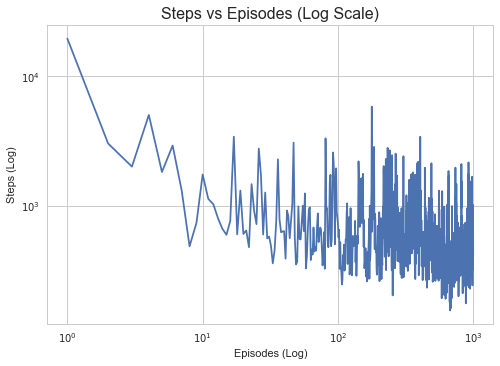

In [8]:
# Create graph for step vs episodes
y = count_step
x = np.arange(1, len(y) + 1)

plt.plot(x, y)
plt.title("Steps vs Episodes (Log Scale)", fontsize=16)
plt.xlabel("Episodes (Log)")
plt.ylabel("Steps (Log)")
plt.xscale('log')
plt.yscale('log')

plt.show()

The line plot visualise the table that are explained above. On the y axis, the plot displays steps taken on each episode, while on the x axis the number of episodes (1000 in the simulation). The line plot is displayed in log-log scale to make it easy to visualise small fluctuation within episode and making sure that large steps in first few episodes don't dominate the graph. From the plot we can see that the overall trend is going downward. The result implies that over many episodes the Q values is getting better and better which eventually will converge to true Q values. Consequently, the agent perform better and better and the step taken to get out of the mountain will decrease with respect to number of episodes.

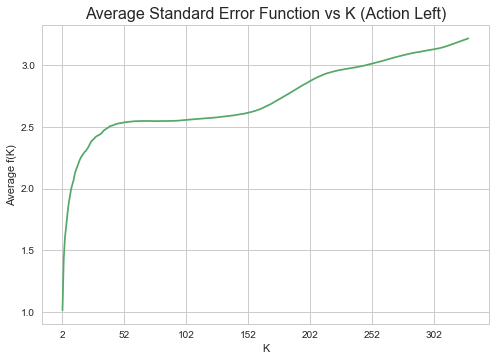

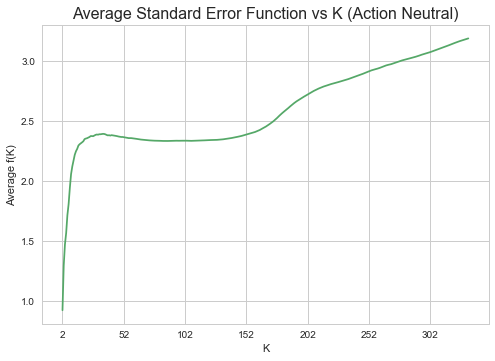

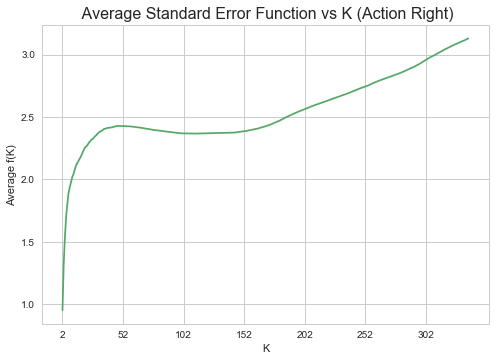

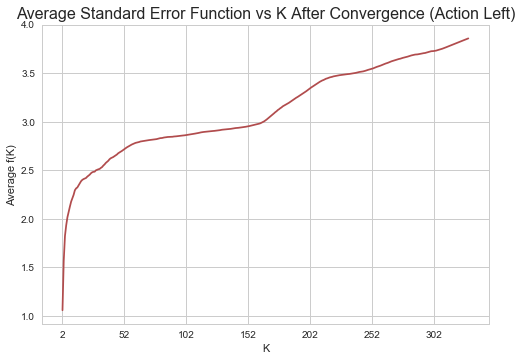

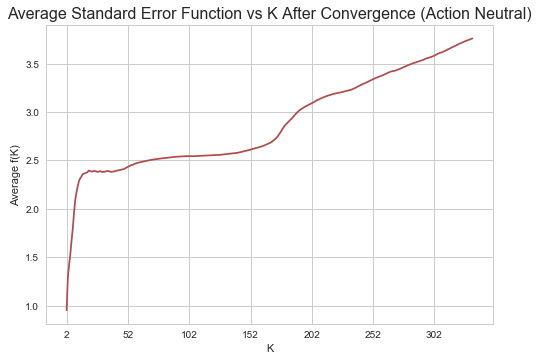

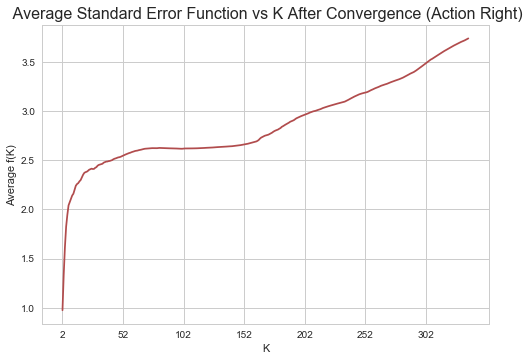

In [9]:
# Create plot for the average standard error function
average_var_left = []
average_var_neutral = []
average_var_right = []

for elem in agent.var_function_left:
    average_var_left.append(elem / total_step)

for elem in agent.var_function_neutral:
    average_var_neutral.append(elem / total_step)

for elem in agent.var_function_right:
    average_var_right.append(elem / total_step)

# Make a scatter plot
# Left
y = average_var_left
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#55A868")
plt.title("Average Standard Error Function vs K (Action Left)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

# Make a scatter plot
# Neutral
y = average_var_neutral
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#55A868")
plt.title("Average Standard Error Function vs K (Action Neutral)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()


# Make a scatter plot
# Right
y = average_var_right
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#55A868")
plt.title(" Average Standard Error Function vs K (Action Right)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

# Now plot the standard error function after convergence
reverse_count_step = count_step[::-1]
total_last_step = 0
for i in range(convergence):
    total_last_step += reverse_count_step[i]

average_converge_left = []
average_converge_neutral = []
average_converge_right = []

for elem in agent.converge_function_left:
    average_converge_left.append(elem / total_last_step)

for elem in agent.converge_function_neutral:
    average_converge_neutral.append(elem / total_last_step)

for elem in agent.converge_function_right:
    average_converge_right.append(elem / total_last_step)

# Make a scatter plot
# Left
y = average_converge_left
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#B14C4D")
plt.title("Average Standard Error Function vs K After Convergence (Action Left)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

# Make a scatter plot
# Neutral
y = average_converge_neutral
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#B14C4D")
plt.title("Average Standard Error Function vs K After Convergence (Action Neutral)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()


# Make a scatter plot
# Right
y = average_converge_right
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#B14C4D")
plt.title(" Average Standard Error Function vs K After Convergence (Action Right)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

The first 3 graphs display average standard error function calculated for every steps from episode 1 - episode 1000. X axis display the possible k for every actions, while y axis display the average standard error function for each k. From both the plot above and bar plot below, it can be seen that k = 2 is chosen most of the time since it's mostly minimise the standard error function compare to other k. Even though 2 is the most frequent k chosen, if we dissect the plot for every episodes, it is not always the case. On some steps/ episodes, the graph are dominated by the number of neighbourhood which makes the graph looks like 1/sqrt(n) resulted in large amount of k (200-300) chosen.

The last 3 graphs display average standard error function calculated for the last 100 episodes out of 1000 episodes (converges). These graphs have similar value with the first 3 graphs and hence the explanation is similar.

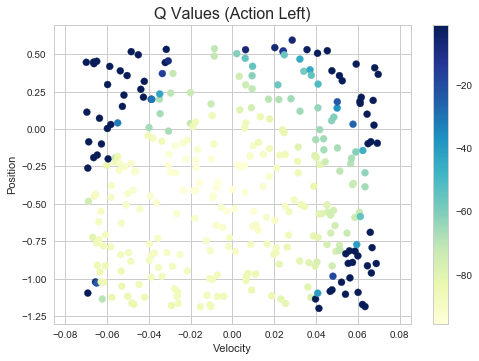

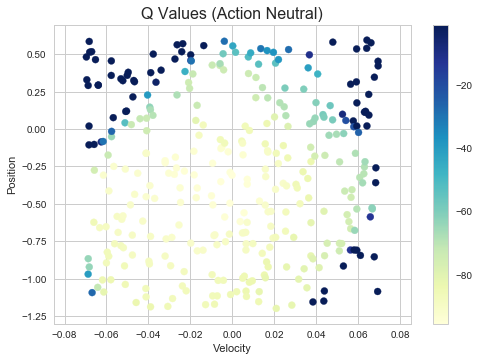

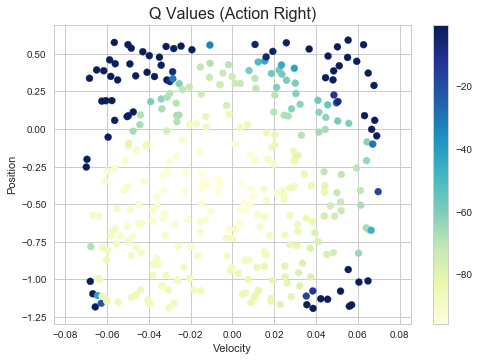

In [10]:
# Create heatmap for Q values
data = pd.DataFrame()
data_left = []
data_neutral = []
data_right = []

position_left = []
position_neutral = []
position_right = []

velocity_left = []
velocity_neutral = []
velocity_right = []

# Sort q_storage based on position and velocity
q_storage_sorted = sorted(agent.q_storage, key=lambda k: k['state'][0])  
# Separate action left, neutral, and right
for elem in q_storage_sorted:
    if (elem["action"] == -1):
        data_left.append(elem["value"])
        position_left.append(elem["state"][1])
        velocity_left.append(elem["state"][0])
    elif (elem["action"] == 0):
        data_neutral.append(elem["value"])
        position_neutral.append(elem["state"][1])
        velocity_neutral.append(elem["state"][0])
    else:
        data_right.append(elem["value"])
        position_right.append(elem["state"][1])
        velocity_right.append(elem["state"][0])

# Make scatter plot for 3 actions (left, neutral, right)
# Left
plt.scatter(x=velocity_left, y=position_left, c=data_left, cmap="YlGnBu")
plt.title("Q Values (Action Left)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Neutral
plt.scatter(x=velocity_neutral, y=position_neutral, c=data_neutral, cmap="YlGnBu")
plt.title("Q Values (Action Neutral)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Right
plt.scatter(x=velocity_right, y=position_right, c=data_right, cmap="YlGnBu")
plt.title("Q Values (Action Right)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

Three scatter plots above display Q values for every action on the last episode (1000). Y axis represents position and x axis represents velocity of the 1000 points that we scattered random uniformly initially. To represent Q values for every point, these scatter plots use color indicating the value that can be seen from the color bar. When the point is darker, the Q value is around -20. On the other hand, if the point is lighter the Q value is around -100.

If we observe the Q values for both KNN-TD and PNA, it can be seen that the Q values are roughly similar. This result implies that both of the algorithm converges for the Mountain Car problem and eventually after numerous episodes, the agent Q values will converge to the true Q values.

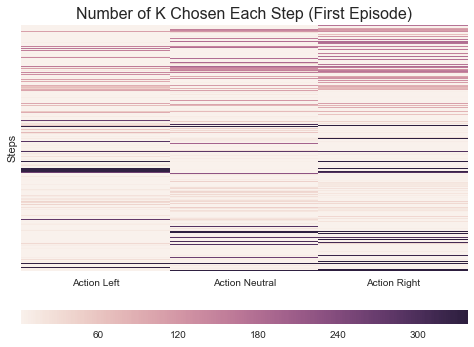

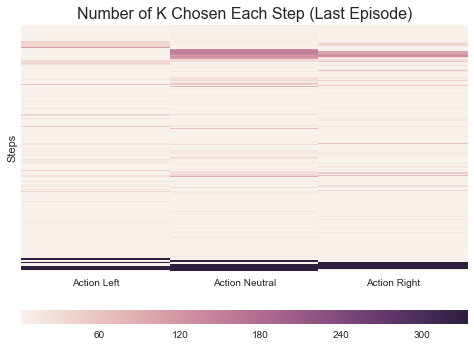

In [11]:
# Create heatmap showing the k (first episode)
data = pd.DataFrame()
data["Action Left"] = k_first_left
data["Action Neutral"] = k_first_neutral
data["Action Right"] = k_first_right
data["Steps"] = np.arange(1, len(k_first_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (First Episode)", fontsize=16)

plt.show()

# Create heatmap showing the k (last episode)
data = pd.DataFrame()
data["Action Left"] = k_last_left
data["Action Neutral"] = k_last_neutral
data["Action Right"] = k_last_right
data["Steps"] = np.arange(1, len(k_last_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (Last Episode)", fontsize=16)

plt.show()

The heatmap displayed above represents k chosen each step for every actions. Each strip on the heatmap represents the k chosen on a step. The first heatmap displayed data from the first episode. Based on the heatmap, it can be seen that the k chosen each step during the first episode is large (around 120-180). This occurs because all points are initialise to have a uniform value of -1. As the Q values is uniformly/ roughly -1 across the whole space, this will make the variance approximately 0 and hence resulted in the standard error function depends largely on the number of k chosen/ neighbourhoods. As the algorithm prefer to minimise the standard error function, it will chooses as many point as possible. 

The second heatmap displayed data from the last episode. Based on the heatmap, it can be seen that the k chosen each step is relatively small (around 2-60). This occurs since the agent has gain large amount of experience and Q values greatly differ in different region. As a result, if the agent choose a really large k to learn, it will make the variance very high and hence really large standard error. Consequently, the agent will minimise standard error function by repeatedly choose k around 2-60.

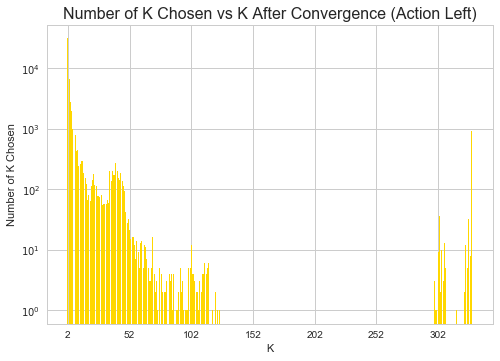

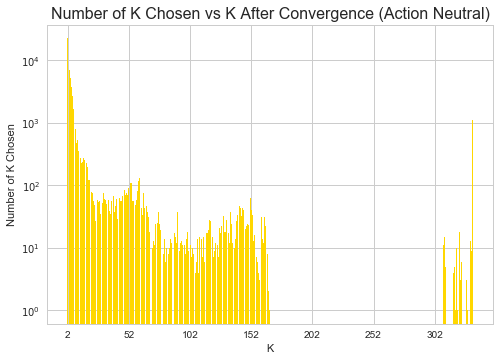

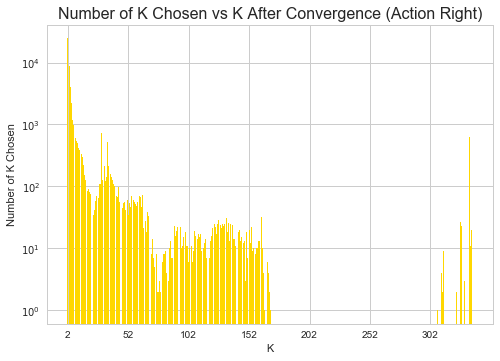

In [22]:
# Plot bar chart displaying number of k chosen after convergence
y_bar = k_convergence_left
x_bar = np.arange(2, len(y_bar) + 2)

plt.bar(x_bar, y_bar, color="#FFD700")
plt.yscale('log')
plt.title("Number of K Chosen vs K After Convergence (Action Left)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Number of K Chosen")
plt.xticks(np.arange(2, len(y_bar) + 2, 50))
plt.show()

y_bar = k_convergence_neutral
x_bar = np.arange(2, len(y_bar) + 2)

plt.bar(x_bar, y_bar, color="#FFD700")
plt.yscale('log')
plt.title("Number of K Chosen vs K After Convergence (Action Neutral)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Number of K Chosen")
plt.xticks(np.arange(2, len(y_bar) + 2, 50))
plt.show()

y_bar = k_convergence_right
x_bar = np.arange(2, len(y_bar) + 2)

plt.bar(x_bar, y_bar, color="#FFD700")
plt.yscale('log')
plt.title("Number of K Chosen vs K After Convergence (Action Right)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Number of K Chosen")
plt.xticks(np.arange(2, len(y_bar) + 2, 50))
plt.show()

These bar plots represent the number of k chosen for each k after convergence for every actions. X axis represents possible k for each action, while y axis represents how many times the k chosen for a particular k after convergence. The convergence defined in the code is the last 100 episodes out of 1000 episodes.

In all of bar plots, we can see that after convergence the agent mostly choose k equals 2 and relatively small k such as from 2 - 150. This condition occurs because the agent has lots of experience which thus make the Q values highly differ between region. Based on the result, we can see that mostly variance dominates the standard error function which force the agent to choose small k to minimise the standard error function.